<a href="https://colab.research.google.com/github/lookingglasslab/VisualFeatureSearch/blob/widen-support/notebooks/Interactive_Visual_Feature_Search_Chest_Xray_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Visual Feature Search
## Chest X-Ray Demo

This notebook implements the Chest X-ray experiment from our [2023 paper](https://openreview.net/pdf?id=JqfN8vp1ov), where we use Visual Feature Search to identify the regions of an image that are most relevant to pathology classification labels. We use the [NIH Chest X-ray dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) and models from [torchxrayvision](https://github.com/mlmed/torchxrayvision) for this experiment.

## Environment Setup

In [ ]:
!wget https://azcopyvnext.azureedge.net/release20220511/azcopy_linux_amd64_10.15.0.tar.gz
!tar -xvf azcopy_linux_amd64_10.15.0.tar.gz

!pip install zarr
!pip install torchxrayvision

# get the X-ray dataset
!wget -O imgs.tar.gz https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz
!tar xzf imgs.tar.gz

# copy our feature cache for the torchxrayvision model
!./azcopy_linux_amd64_10.15.0/azcopy copy https://vissearch.blob.core.windows.net/data/XRV_DenseNet_ALL_08242023.tar.gz XRV_DenseNet_ALL_08242023.tar.gz
!tar -xzf XRV_DenseNet_ALL_08242023.tar.gz

!wget https://vissearch.blob.core.windows.net/data/NIH-Data_Entry_2017_v2020.csv

In [ ]:
# TODO: change to regular pip upon release
!pip install -i https://test.pypi.org/simple/ --no-deps visualfeaturesearch==0.0.11

In [ ]:
import sys

import torch
from torchvision import transforms
import zarr
import pandas as pd
import skimage
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torchxrayvision as xrv

sys.path.append('../')
import visualfeaturesearch as vfs
from visualfeaturesearch.searchtool import CachedSearchTool

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  raise Exception('No GPU available')

## Initialize model, dataset, and search tool

In [ ]:
model = xrv.models.DenseNet(weights='densenet121-res224-all').to(device)
model.op_threshs = torch.tensor(xrv.models.model_urls['all']['ppv80_thres']).to(device)
model_feats = model.features # get the final feature tensors (of shape 1024x7x7)
model_feats = model_feats.eval().to(device)

cache_store = zarr.DirectoryStore('XRV_DenseNet_ALL_08242023')
cache_root = zarr.group(store=cache_store, overwrite=False)
cache_feats_data = np.float32(cache_root['feats'][:])

cached_search_tool = CachedSearchTool(model_feats, cache_feats_data, device, batch_size=5000)

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [ ]:
nih_csv = pd.read_csv('NIH-Data_Entry_2017_v2020.csv')
nih_csv = nih_csv[:4999]

transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224)
])

def get_nih_image(idx):
  query_img_name = nih_csv.iloc[idx]['Image Index']
  query_img = skimage.io.imread(f'images/{query_img_name}')
  query_img_model = xrv.datasets.normalize(query_img, 255, reshape=True)
  query_img_model = torch.as_tensor(transform(query_img_model))
  return query_img_model

def model_img_to_PIL(img):
  img_vis = (img + 1024) / 2048 * 255
  img_vis = Image.fromarray(np.uint8(img_vis[0,:,:]))
  return img_vis

Setting XRayResizer engine to cv2 could increase performance.


## Search tool

For our experiment in the paper, we studied a patient with cardiomegaly (the presence of an enlarged heart). The patient's X-ray is the first image in the widget below. Our experiment involved first highlighting the patient's heart and searching for other images in the dataset, followed by searching for an unrelated region of the image (such as the patient's right lung).

In [ ]:
QUERY_IDXS = list(range(0, 2000, 200))

model_imgs = [get_nih_image(idx) for idx in QUERY_IDXS]
vis_imgs = [model_img_to_PIL(img).convert('RGB') for img in model_imgs]
query_img_urls = [vfs.util.image_to_durl(img) for img in vis_imgs]

highlight_data = None
highlight_index = None
test_data = None
def highlight_callback(data):
    global highlight_data, highlight_index
    if isinstance(data, str): # the data get returned in different formats for Colab and Jupyter notebook
        data = data.rsplit(',', 1)
    highlight_data = data[0]
    highlight_index = int(data[1])
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.MultiHighlightWidget(all_urls=query_img_urls, callback_name='highlight_callback')

In [ ]:
assert highlight_data is not None, "Use the widget to highlight an image region"

selected_idx = int(highlight_index)
mask = vfs.util.durl_to_image(highlight_data)

cached_search_tool.set_input_image(model_imgs[selected_idx])

# turn the user's highlighted mask into a 7x7 grayscale array
mask_transform = transforms.Resize(7)
mask_7x7 = mask_transform(mask)
mask_7x7_arr = np.asarray(mask_7x7)[:,:,3] / 255
mask_7x7_arr = np.float32(mask_7x7_arr)

print('Loading results...')
region_sims, region_xs, region_ys = cached_search_tool.compute(mask_7x7_arr)
sim_order = torch.argsort(region_sims, descending=True)
print('Done.')

nih_csv['Cosine Similarity'] = region_sims.cpu().numpy()
sorted_csv = nih_csv.sort_values(by='Cosine Similarity', ascending=False).reset_index()
sorted_csv[:6][['Finding Labels', 'Patient ID', 'Patient Age', 'Patient Gender', 'Cosine Similarity']]

Loading results...
Done.


,Finding Labels,Patient ID,Patient Age,Patient Gender,Cosine Similarity
0,Cardiomegaly,1,57,M,0.999997
1,Cardiomegaly|Effusion,38,75,M,0.922650
2,Cardiomegaly|Emphysema,968,68,F,0.907480
3,Infiltration,131,63,M,0.904989
4,Cardiomegaly,845,65,F,0.903925
5,Atelectasis|Infiltration,38,75,M,0.900877


The above table shows that the search query (row 0) has a ground truth label of Cardiomegaly, while several of the nearest neighbors have cardiomegaly present as well. We also display the top 5 results below, along with their similarity scores and whether Cardiomegaly is present in each of them or not.

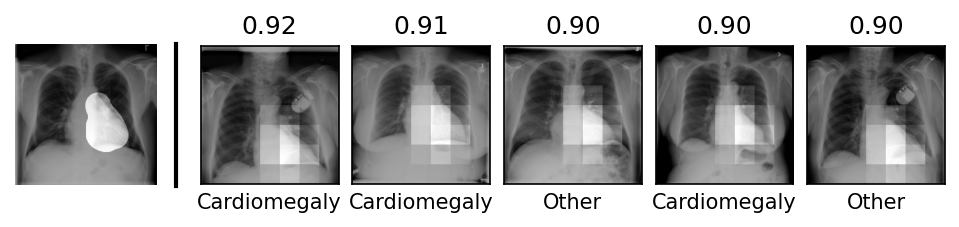

In [ ]:
# set up the figure
DISPLAY_NUM = 5

fig = plt.figure(figsize=(8, 5.15), dpi=150)
# fig.suptitle('Nearest Neighbors', fontweight='bold', y=0.75)
gs = fig.add_gridspec(1,2, width_ratios=[0.95,5])
fig.subplots_adjust(wspace=0.1, hspace=0)
results_gs = gs[1].subgridspec(1,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_imgs[selected_idx], 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
line_x_val = 255
ax.add_line(matplotlib.lines.Line2D([line_x_val,line_x_val], [0,224], lw=2, color='black')).set_clip_on(False)

# include the most similar images from the dataset on the right side
for i in range(DISPLAY_NUM):
  idx = sim_order[i+1].cpu().numpy()
  img = model_img_to_PIL(get_nih_image(idx))
  curr_img_out = vfs.util.mask_overlay(img,
                                   x=region_xs[idx],
                                   y=region_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(mask_7x7_arr))

  ax = fig.add_subplot(results_gs[i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{region_sims[idx].cpu().numpy():.02f}')
  sub_str = 'Cardiomegaly' if 'Cardiomegaly' in sorted_csv.iloc[i+1]["Finding Labels"] else 'Other'
  ax.set_xlabel(f'{sub_str}')

Text(0, 0.5, 'Cardiomegaly\nPresent')

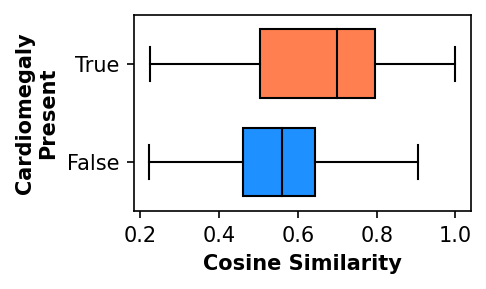

In [ ]:
sorted_csv['Cardiomegaly Present'] = sorted_csv['Finding Labels'].str.contains('Cardiomegaly')

sims_with_cardiomegaly = sorted_csv[sorted_csv['Cardiomegaly Present']]['Cosine Similarity'].to_numpy()
sims_without_cardiomegaly = sorted_csv[sorted_csv['Cardiomegaly Present'] == False]['Cosine Similarity'].to_numpy()
plt.figure(figsize=(2.9, 1.7), dpi=150)

boxplot = plt.boxplot(x=[sims_without_cardiomegaly, sims_with_cardiomegaly],
            labels=[False, True], vert=False, widths=.7, patch_artist=True)
for median in boxplot['medians']:
    median.set_color('black')

colors = ['dodgerblue', 'coral']
for i in range(2):
    boxplot['boxes'][i].set_facecolor(colors[i])

plt.xticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel('Cosine Similarity', fontweight='bold')
plt.ylabel('Cardiomegaly\nPresent', fontweight='bold')

We also plot the distributions of similarity scores for all images in the dataset, grouped by the presence of cardiomegaly. We see that when the heart is highlighted for the search query, the images in the dataset that also contain cardiomegaly have higher similarity scores than those that do not; meanwhile, if an unrelated part of the image above is highlighted and queried, the distributions tend to look very similar. This indicates that there is a correlation between the model's features around a patient's heart and the presence of cardiomegaly.